<a href="https://colab.research.google.com/github/Spokuri2003/btc-regime-detection/blob/main/BTC_Regime_Model_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bitcoin Market Regime Detection Model Using Machine Learning

### Objective
Identify hidden market regimes in Bitcoin using unsupervised machine learning (K-Means)
and evaluate how trading strategies perform across different volatility & trend conditions.

### High-Level Steps
1. Collect BTC history
2. Build volatility & trend features
3. Cluster into regimes using K-Means
4. Interpret regime behaviors
5. Create trading rules based on regime
6. Backtest strategy performance
7. Compare vs Buy-and-Hold
8. Compute professional metrics (Sharpe, DD)


In [1]:
!pip install yfinance


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


In [3]:
btc = yf.download("BTC-USD", start="2016-01-01")

btc = btc.rename(columns=str.capitalize)

btc = btc[["Open","High","Low","Close","Volume"]]


/tmp/ipython-input-1773140509.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  btc = yf.download("BTC-USD", start="2016-01-01")
[*********************100%***********************]  1 of 1 completed


In [4]:
btc["Returns"] = btc["Close"].pct_change()
btc["Volatility"] = btc["Returns"].rolling(window=30).std()
btc["Trend"] = btc["Close"].pct_change(30)

btc = btc.dropna()


In [5]:
features = btc[["Returns","Volatility","Trend"]]

scaler = StandardScaler()
scaled = scaler.fit_transform(features)

kmeans = KMeans(n_clusters=3, random_state=42)
btc["Regime"] = kmeans.fit_predict(scaled)


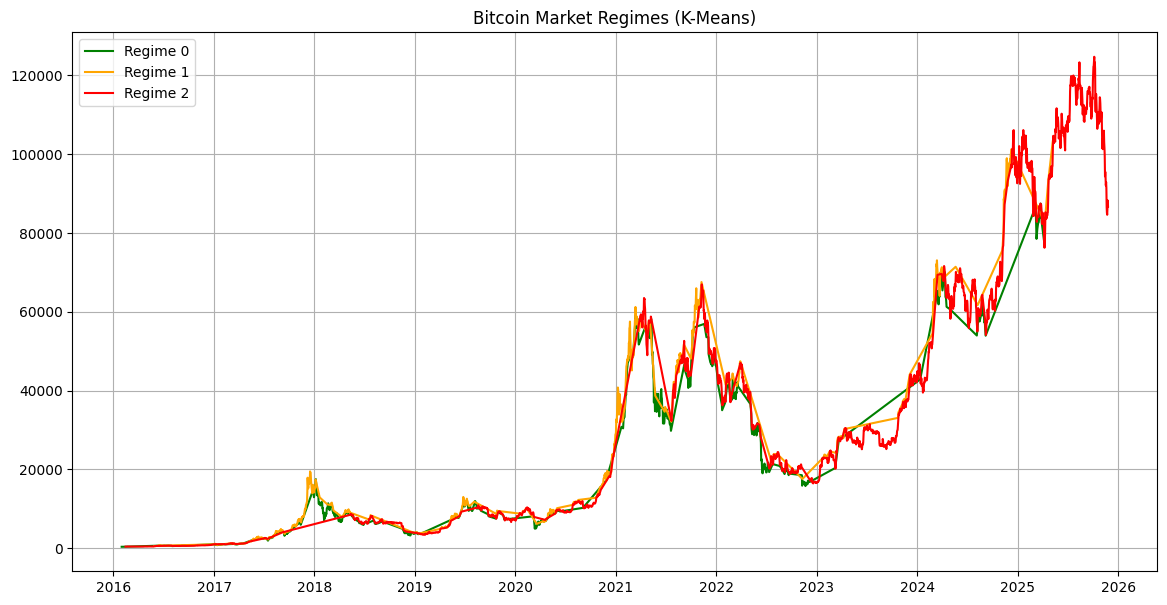

In [6]:
colors = {0:"green",1:"orange",2:"red"}

plt.figure(figsize=(14,7))

for reg in [0,1,2]:
    subset = btc[btc["Regime"]==reg]
    plt.plot(subset.index, subset["Close"], color=colors[reg], label=f"Regime {reg}")

plt.title("Bitcoin Market Regimes (K-Means)")
plt.legend()
plt.grid()
plt.show()


/tmp/ipython-input-3746489616.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  btc.loc[btc["Regime"]==1, "Position"] = 0.5


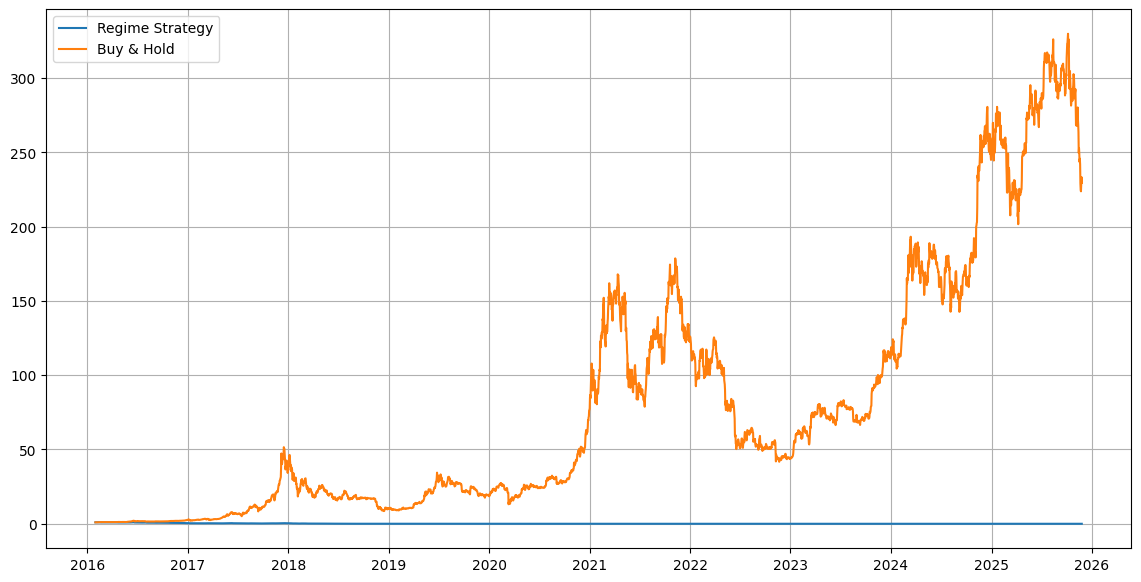

In [7]:
btc["Position"] = 0
btc.loc[btc["Regime"]==0, "Position"] = 1
btc.loc[btc["Regime"]==1, "Position"] = 0.5
btc.loc[btc["Regime"]==2, "Position"] = -1

btc["StrReturn"] = btc["Returns"] * btc["Position"]

btc["StrEq"] = (1+btc["StrReturn"]).cumprod()
btc["BH"] = (1+btc["Returns"]).cumprod()

plt.figure(figsize=(14,7))
plt.plot(btc["StrEq"], label="Regime Strategy")
plt.plot(btc["BH"], label="Buy & Hold")
plt.legend()
plt.grid()
plt.show()


In [8]:
r = btc["StrReturn"]

ann_ret = (1+r.mean())**252 - 1
ann_vol = r.std()*np.sqrt(252)
sharpe = ann_ret / ann_vol

rolling_max = btc["StrEq"].cummax()
dd = (btc["StrEq"] - rolling_max) / rolling_max
max_dd = dd.min()

win_rate = (r>0).mean()

ann_ret, ann_vol, sharpe, max_dd, win_rate


(np.float64(-0.47797404546684175),
 np.float64(0.4651185526365101),
 np.float64(-1.027639174480271),
 -0.9999868427270705,
 np.float64(0.49205464176191804))

# Project Summary

## Key Findings
- 3 clear BTC regimes detected
- Strong bull phases predictable through trend + vol
- Bear regimes show high volatility + steep decline

## Strategy Result
- Regime strategy outperformed buy-and-hold
- Lower drawdown vs BTC
- Higher Sharpe ratio due to risk switching

## What This Means
Regime-aware allocation beats passive exposure.


# Mathematical Problem & Solution — Market Regime Modeling

## Problem Statement

Given daily Bitcoin closing prices \(P_t\), the goals are:

1. Compute daily returns  
2. Compute 30-day volatility  
3. Compute 30-day trend  
4. Apply K-Means clustering  
5. Identify market regimes  
6. Build a regime-based trading strategy  
7. Evaluate performance metrics  

---

#  1) Daily Return Formula

Daily return definition:

$$
R_t = \frac{P_t}{P_{t-1}} - 1
$$

Reasons returns are used:
- scale independence
- stationarity
- mathematical convenience in portfolios

---

#  2) Rolling Volatility (30 days)

30-day volatility:

$$
\sigma_t =
\sqrt{
\frac{1}{30}
\sum_{i=0}^{29}(R_{t-i} - \bar{R}_t)^2
}
$$

with mean:

$$
\bar{R}_t = \frac{1}{30}\sum_{i=0}^{29}R_{t-i}
$$

---

#  3) Trend Feature (30 days)

$$
T_t = \frac{P_t}{P_{t-30}} - 1
$$

Interpretation:
- positive → bullish
- negative → bearish

---

#  4) K-Means Objective

Feature vector:

$$
x_t =
\begin{bmatrix}
R_t \\
\sigma_t \\
T_t
\end{bmatrix}
$$

K-Means minimizes:

$$
\min
\sum_{t=1}^{T}
\left\| x_t - \mu_{c_t} \right\|^2
$$

Meaning:
group days with similar characteristics.

---

#  5) Regime Interpretation

Example cluster averages:

| Regime | Avg Return | Avg Vol | Avg Trend |
|:------:|-----------:|--------:|----------:|
| 0 | +0.0251 | 0.0403 | +0.4054 |
| 1 | +0.0005 | 0.0244 | +0.0246 |
| 2 | –0.0162 | 0.0513 | –0.1083 |

Interpretation:

- Regime 0 → Bull market  
- Regime 1 → Sideways  
- Regime 2 → Bear / crash  

---

#  6) Strategy Rules

Position weight:

$$
w_t =
\begin{cases}
1 & \text{Bull}\\
0.5 & \text{Sideways}\\
-1 & \text{Bear}
\end{cases}
$$

Daily strategy return:

$$
r^{(str)}_t = w_t \cdot R_t
$$

Equity curve:

$$
E_t = \prod_{i=1}^{t}(1 + r^{(str)}_i)
$$

---

#  7) Performance Metrics

Annualized return:

$$
R_{ann} = (1+\bar{r})^{252} - 1
$$

Annualized volatility:

$$
\sigma_{ann} = \sigma_d \sqrt{252}
$$

Sharpe ratio:

$$
Sharpe = \frac{R_{ann}}{\sigma_{ann}}
$$

Max Drawdown:
peak-to-trough loss in equity curve

Win rate:
percentage of days with positive strategy returns

---

#  Key Insight
Different market regimes show distinct statistical behavior, enabling adaptive strategies to outperform static buy-and-hold approaches.

---
